# Machine Learning LAB 3: LINEAR REGRESSION

Course 2024/25: *F. Chiariotti*

The notebook contains some simple tasks to be performed with **LINEAR REGRESSION MODELS**.

Complete all the **required code sections**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## VR traffic prediction

In this notebook, we will explore the prediction of Virtual Reality (VR) traffic. The data come from the paper:

Lecci, Mattia, _et al._ "An open framework for analyzing and modeling XR network traffic." IEEE Access 9 (2021): 129782-129795.

The VR game Virus Popper was instantiated on a computer through the RiftCat application: the user could then see the virtual content on their phone, which was strapped to their head with a Cardboard viewer. The file virus_popper.csv contains three columns from the traffic capture:
idx    | frame size (B) |  time (s)
0      | 38424          |  0.0
1      | 39801          |  0.01944
...

The game was run at 60 frames per second, with a target rate of 30 Mb/s. The task is then to predict the size of the next frame, given the past N frames. This was explored in another paper:

Chiariotti, Federico, _et al._ "Temporal characterization and prediction of vr traffic: A network slicing use case." IEEE Transactions on Mobile Computing 23.5 (2023): 3890-3908.

---

## Import all the necessary Python libraries

In [3]:
import numpy as np
import pandas as pd
import random as rnd
from matplotlib import pyplot as plt
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split

np.random.seed(1)

def load_dataset(filename):
    data_train = pd.read_csv(filename)
    data = data_train.iloc[:, 1].values # Get the second column (frame size) as the input
    return data

# Load the dataset
data = load_dataset('data/virus_popper.csv')

## Prepare the data and create training and test sets

In this case, we are learning a time series: let us consider a memory of 2 samples, i.e., use X[n-1] and X[n-2] to predict X[n].

In [4]:
# Normalize the dataset
avg_size = np.mean(data)
norm_data = np.asarray(data) / avg_size

# Compute the splits and prepare the columns
m_training = int(0.75*norm_data.shape[0])

X_training = np.ones([m_training - 2, 3])
X_training[:,1] = norm_data[: m_training - 2]
X_training[:,2] = norm_data[1 : m_training - 1]
Y_training = norm_data[2 : m_training]


X_test = np.ones([norm_data.shape[0] - m_training - 2, 3])
X_test[:,1] = norm_data[m_training : -2]
X_test[:,2] = norm_data[m_training + 1 : -1]
Y_test = norm_data[m_training + 2:]

print(np.shape(X_training), np.shape(Y_training), np.shape(X_test), np.shape(Y_test))

(25878, 3) (25878,) (8625, 3) (8625,)


## Least Squares linear regression

Train and evaluate the LS regressor on the data

In [5]:
# Least squares solution
def least_squares(X_matrix: np.ndarray, labels: np.ndarray) -> None:
    ## TODO: Run the LS algorithm without regularization
    A = np.matmul(X_matrix.T, X_matrix)
    B = np.matmul(X_matrix.T, labels)
    if np.any(np.isclose(np.linalg.det(A), 0)):
        raise ValueError("Matrix A is not invertible")
    return np.matmul(np.linalg.inv(A), B)

def evaluate_model(x, y, coeff):
    ## TODO: Return the average MSE for the set over which we evaluate
    y_predicted = np.matmul(x, coeff)
    mse = np.mean((y_predicted - y)**2)
    return mse

In [6]:
# Run the LS training and test it on the test data
trained_model = least_squares(X_training, Y_training)
mse = evaluate_model(X_test, Y_test, trained_model)
print('Model coefficients:', trained_model)
print('Root MSE:', np.sqrt(mse) * avg_size)

Model coefficients: [0.36986742 0.20348677 0.42565451]
Root MSE: 7712.35472153933


---

## Least Squares with Tikhonov regularization

Perform K-fold cross validation with $\lambda\in\{0, 0.1, 1, 10\}$

In [13]:
# Least squares solution
def regularized_least_squares(X_matrix: np.ndarray, labels: np.ndarray, lambda_par: np.ndarray) -> None:
    ## TODO: Run the LS algorithm with regularization
    lambda_par_normalized = lambda_par / X_matrix.shape[0]
    A = np.matmul(X_matrix.T, X_matrix) + lambda_par_normalized * np.eye(X_matrix.shape[1])
    B = np.matmul(X_matrix.T, labels)
    return np.matmul(np.linalg.inv(A), B)

def K_fold(X_training: np.ndarray, Y_training: np.ndarray, lambda_vec: np.ndarray, K: np.ndarray) -> None:
    ## TODO: Perform K-fold cross-validation
    shuffled_idxs = np.arange(X_training.shape[0])
    np.random.shuffle(shuffled_idxs)
    val_idxs = np.array_split(shuffled_idxs, K)
    fold_idxs = [np.setdiff1d(shuffled_idxs, val_idxs[i]) for i in range(K)]
    best_model = np.zeros(X_training.shape[1])
    best_perf = 10e9
    models = []
    results = []
    for lambda_par in lambda_vec:
        avg_perf = 0
        for k in range(K):
            xt, yt = X_training[fold_idxs[k]], Y_training[fold_idxs[k]]
            xv, yv = X_training[val_idxs[k]], Y_training[val_idxs[k]]
            fold_model = regularized_least_squares(xt, yt, lambda_par)
            avg_perf += evaluate_model(xv, yv, fold_model)/K
        # now on whole dataset
        results.append(avg_perf)
        model = regularized_least_squares(X_training, Y_training, lambda_par)
        models.append(model)
        if avg_perf < best_perf:
            best_model = model
            best_perf = avg_perf
    return best_model, best_perf, models, results

[0.3692979  0.20538401 0.42424695] [np.float64(0.021434472985412508), np.float64(0.021434472863453236), np.float64(0.02143447272307277), np.float64(0.02143447256149617), np.float64(0.021434472375532834), np.float64(0.02143447216151537), np.float64(0.021434471915228938), np.float64(0.021434471631831233), np.float64(0.021434471305760944), np.float64(0.021434470930633283), np.float64(0.02143447049912159), np.float64(0.02143447000282253), np.float64(0.02143446943210385), np.float64(0.021434468775932514), np.float64(0.021434468021680933), np.float64(0.02143446715491065), np.float64(0.021434466159130694), np.float64(0.021434465015530313), np.float64(0.02143446370268535), np.float64(0.021434462196238138), np.float64(0.021434460468554874), np.float64(0.0214344584883624), np.float64(0.021434456220374022), np.float64(0.02143445362491524), np.float64(0.0214344506575687), np.float64(0.021434447268864516), np.float64(0.021434443404055505), np.float64(0.021434439003032178), np.float64(0.021434434000

<>:10: SyntaxWarning: invalid escape sequence '\l'
<>:10: SyntaxWarning: invalid escape sequence '\l'
/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_11754/4253858695.py:10: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


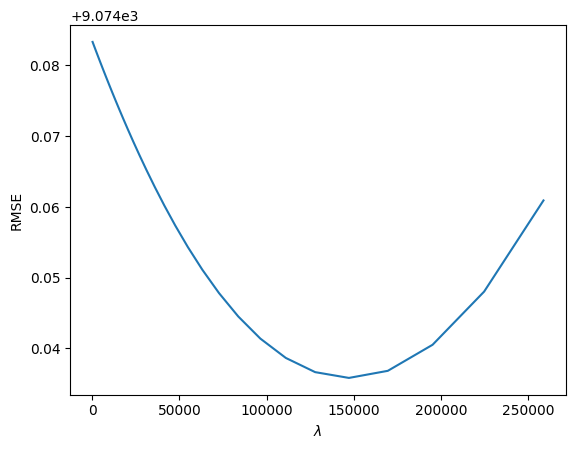

In [17]:
# Run the training with K-fold cross-validation and plot the score
K = 5

# already normalized, ranging from 0.01 to 10
lambda_par = X_training.shape[0] * 10**np.linspace(-2, +1, 50)

best_model, best_perf, models, results = K_fold(X_training, Y_training, lambda_par, K)
print(best_model, results)
plt.plot(lambda_par, np.sqrt(results) * avg_size)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.show()


<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_11754/1799133235.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


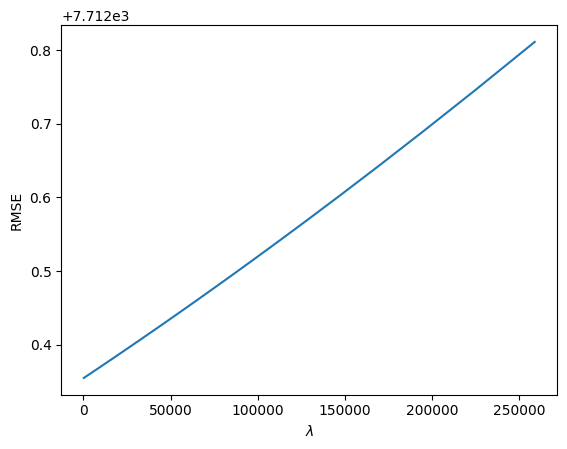

In [18]:
# Plot the results for the regularized models on the test set
test_scores = np.zeros(len(models))

for i in range(len(models)):
    test_scores[i] = evaluate_model(X_test, Y_test, models[i])

plt.plot(lambda_par, np.sqrt(test_scores) * avg_size)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.show()


### EXTRA

Can you figure out the best amount of memory (=== number of frames to predict the size of the next frame, i.e. order of the autoregressive model) to use?


*Answer*
- perform cross validation also for the number of frames, determine when overfitting begins.
- plot autocorrelation between pixels at lag T, determine lag for which correlation drops to zero.